In [1]:
import pandas as pd
import numpy as np
import warnings
import platform
import datetime
import re

# 경고 메시지 무시
warnings.filterwarnings('ignore')

# 시각화 설정
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns

# 한글 폰트 설정
if platform.system() == 'Windows':
    plt.rcParams['font.family'] = 'Malgun Gothic'
else:
    plt.rcParams['font.family'] = 'AppleGothic'
matplotlib.rc('axes', unicode_minus=False)

# 데이터 분할 및 전처리
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE

# 회귀 모델 및 변수 선택
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.feature_selection import RFE
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import variance_inflation_factor

# 분류 및 회귀 모델
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, export_graphviz
from sklearn.ensemble import (
    RandomForestClassifier,
    GradientBoostingClassifier,
    RandomForestRegressor,
    GradientBoostingRegressor
)

# 평가 지표
from sklearn.metrics import (
    mean_squared_error,
    mean_absolute_error,
    mean_absolute_percentage_error,
    r2_score,
    confusion_matrix,
    classification_report,
    accuracy_score,
    roc_auc_score
)

# 통계 검정
from scipy.stats import shapiro, ttest_ind, chi2_contingency

# 나무 시각화
# import graphviz

In [2]:
# 출력 제한 해제
pd.set_option('display.max_rows', None)     # 행 모두 보기
pd.set_option('display.max_columns', None)  # 열 모두 보기
pd.set_option('display.width', None)        # 가로 너비 무제한
pd.set_option('display.max_colwidth', None) # 컬럼 내용 모두 출력

## 정제된 데이터 불러오기

In [3]:
df_emp = pd.read_csv('/Users/minjoo/PoscoBAA/BigData/BigData_Project/Code/정제후데이터/df_emp_cleaned.csv', encoding='euc-kr')
df_retired = pd.read_csv('/Users/minjoo/PoscoBAA/BigData/BigData_Project/Code/정제후데이터/df_retired_cleaned.csv', encoding='euc-kr')
dft_emp = pd.read_csv('/Users/minjoo/PoscoBAA/BigData/BigData_Project/Code/정제후데이터/dft_emp.csv', encoding='euc-kr')
dft_retired = pd.read_csv('/Users/minjoo/PoscoBAA/BigData/BigData_Project/Code/정제후데이터/dft_retired.csv', encoding='euc-kr')

## cf) 범주형 데이터 -> 더미화한 변수랑 안한거랑 나누기
- 매핑 + (더미화 X) : df_retired, df_emp
- 매핑 + 더미화 : df_retired_dummy, df_emp_dummy

#### 퇴직자

In [4]:
import pandas as pd

# 👉 먼저 원본 데이터프레임 복사 (여기선 df_retired가 원본)
df_retired = df_retired.copy()  # 숫자 매핑만 적용
df_retired_dummy = df_retired.copy()  # 숫자 매핑 + 더미화

# -----------------------------------
# 숫자 매핑 (두 개의 데이터프레임 모두에 적용)
# -----------------------------------

education_map = {
    '대학원': 1, '대학교': 2, '전문대': 3, '고등학교': 4, '중학교': 5
}
incomeclass_map = {
    '3000만원 미만': 1,
    '3000만원~5000만원 미만': 2,
    '5000만원~1억원 미만': 3,
    '1억원 이상': 4
}
residence_map = {
    '최상': 1,
    '양호': 2,
    '평균': 3,
}
week_map = {
    '월': 1, '화': 2, '수': 3, '목': 4, '금': 5
}

def classify_accompany(x):
    if x in ['배우', '기타', '자녀', '친지', '단체']:
        return '동행'
    elif x == '단독':
        return '단독'
    else:
        return

# 숫자 매핑 - 두 데이터프레임 모두에 동일하게 적용
for df in [df_retired, df_retired_dummy]:
    df['Education'] = df['Education'].map(education_map)
    df['IncomeClass'] = df['IncomeClass'].map(incomeclass_map)
    df['ResidenceClass'] = df['ResidenceClass'].map(residence_map)
    df['ApplWeek'] = df['ApplWeek'].map(week_map)
    df['Accompany'] = df['Accompany'].apply(classify_accompany)

# -----------------------------------
# df_retired_dummy만 get_dummies 처리
# -----------------------------------


cols_get_dummy = [
    'Gender', 'MaritalStatus', 'IncomeType', 'OrgType',
    'HouseOwnYN', 'CarOwnedYN', 'ActiveLoanYN', 'LoanType', 'HousingType',
    'Accompany', 'InterestType', 'HomeAddMatchedYN', 'WorkAddMatchedYN',
    'Occupation', 'DwellingType', 'Education','IncomeClass','ResidenceClass'
]

df_retired_dummy = pd.get_dummies(df_retired_dummy, columns=cols_get_dummy, drop_first=False)


#### 재직자

In [5]:
import pandas as pd

# 👉 먼저 원본 데이터프레임 복사 (여기선 df_emp가 원본)
df_emp = df_emp.copy()  # 숫자 매핑만 적용
df_emp_dummy = df_emp.copy()  # 숫자 매핑 + 더미화

# -----------------------------------
# 숫자 매핑 (두 개의 데이터프레임 모두에 적용)
# -----------------------------------

education_map = {
    '대학원': 1, '대학교': 2, '전문대': 3, '고등학교': 4, '중학교': 5
}
incomeclass_map = {
    '3000만원 미만': 1,
    '3000만원~5000만원 미만': 2,
    '5000만원~1억원 미만': 3,
    '1억원 이상': 4
}
residence_map = {
    '최상': 1,
    '양호': 2,
    '평균': 3,
}
week_map = {
    '월': 1, '화': 2, '수': 3, '목': 4, '금': 5
}

def classify_accompany(x):
    if x in ['배우', '기타', '자녀', '친지', '단체']:
        return '동행'
    elif x == '단독':
        return '단독'
    else:
        return

# 숫자 매핑 & 파생변수 생성 - 두 데이터프레임 모두에 동일하게 적용
for df in [df_emp, df_emp_dummy]:
    df['Education'] = df['Education'].map(education_map)
    df['IncomeClass'] = df['IncomeClass'].map(incomeclass_map)
    df['ResidenceClass'] = df['ResidenceClass'].map(residence_map)
    df['ApplWeek'] = df['ApplWeek'].map(week_map)
    df['Accompany'] = df['Accompany'].apply(classify_accompany)

# -----------------------------------
# df_emp_dummy만 get_dummies 처리
# ----------------------------------

cols_get_dummy = [
    'Gender', 'MaritalStatus', 'IncomeType', 'OrgType',
    'HouseOwnYN', 'CarOwnedYN', 'ActiveLoanYN', 'LoanType', 'HousingType',
    'Accompany', 'InterestType', 'HomeAddMatchedYN', 'WorkAddMatchedYN',
    'Occupation', 'DwellingType', 'Education','IncomeClass','ResidenceClass'
]

df_emp_dummy = pd.get_dummies(df_emp_dummy, columns=cols_get_dummy, drop_first=False)


# 연체 예측 : 모델링
- 변수의 유의성 판단
    - t-test : 연속형
    - chi-squared test : 범주형
- 모델링
    - CatBoost
    - Decision Tree
    - lightGBM

## 변수의 유의성 판단

#### 재직자

### T - test 를 통해 연속형 변수들의 유의미한 변수 추출

In [6]:
# 수치형 변수 (Default 제외)
num_cols = [
    'Age', 'FamilyCount', 'ChildCount', 'EmployedYears',
    'ApplHour', 'CarPrice', 'Deposit', 'LoanTerm', 'LoanRemainTerm',
    'InterestRate', 'LoanAmount', 'InstallAmount', 'LoanRemainAmount',
    'InquiryCount', 'IdChangedYears', 'InfoChangedYears', 'PhoneChangedYears',
]

# 결과 저장
ttest_results = []

for col in num_cols:
    group0 = df_emp[df_emp['Default'] == 0][col]
    group1 = df_emp[df_emp['Default'] == 1][col]

    t_stat, p_val = ttest_ind(group0, group1, equal_var=False, nan_policy='omit')
    ttest_results.append({'변수': col, 'p-value': round(p_val, 4)})  # 여기 반올림 적용

# 결과 정리
ttest_df = pd.DataFrame(ttest_results).sort_values(by='p-value')

# 유의미한 변수만 보기 (p < 0.05)
significant = ttest_df[ttest_df['p-value'] < 0.05]

# 출력
print("전체 t-test 결과:\n", ttest_df)
print("\n유의미한 변수들 (p < 0.05):\n", significant)


전체 t-test 결과:
                    변수  p-value
0                 Age   0.0000
3       EmployedYears   0.0000
16  PhoneChangedYears   0.0000
9        InterestRate   0.0002
13       InquiryCount   0.0008
15   InfoChangedYears   0.0056
14     IdChangedYears   0.0124
10         LoanAmount   0.0339
5            CarPrice   0.0409
4            ApplHour   0.0553
1         FamilyCount   0.0713
11      InstallAmount   0.3203
12   LoanRemainAmount   0.4517
2          ChildCount   0.6200
6             Deposit   0.7747
7            LoanTerm   0.7798
8      LoanRemainTerm   0.9485

유의미한 변수들 (p < 0.05):
                    변수  p-value
0                 Age   0.0000
3       EmployedYears   0.0000
16  PhoneChangedYears   0.0000
9        InterestRate   0.0002
13       InquiryCount   0.0008
15   InfoChangedYears   0.0056
14     IdChangedYears   0.0124
10         LoanAmount   0.0339
5            CarPrice   0.0409


### 카이제곱 검정을 통해 유의미한 문자형 변수 추출 

In [7]:
from scipy.stats import chi2_contingency
import pandas as pd

# ✅ 원본 범주형 변수 (더미화 X)
cat_vars = [
  'Gender', 'Education', 'MaritalStatus', 'IncomeType', 'IncomeClass', 
            'Occupation', 'OrgType', 'HouseOwnYN', 'DwellingType', 'HousingType', 
            'ResidenceClass', 'CarOwnedYN', 'ActiveLoanYN', 'LoanType', 'ApplWeek', 
            'HomeAddMatchedYN', 'WorkAddMatchedYN'
]

chi_results = []

# ✅ 변수별 카이제곱 검정
for col in cat_vars:
    try:
        table = pd.crosstab(df_emp[col], df_emp['Default'])

        if table.shape[0] >= 2 and table.shape[1] >= 2:
            chi2, p, dof, expected = chi2_contingency(table)
            chi_results.append({'변수': col, 'p_value': p})
    except Exception as e:
        print(f"⚠️ {col} 오류: {e}")

# ✅ 결과 정리 및 출력
chi_df = pd.DataFrame(chi_results)

if not chi_df.empty:
    chi_df['p_value'] = chi_df['p_value'].round(4)
    chi_df = chi_df.sort_values(by='p_value')

    print("✅ 유의미한 변수 목록 (p < 0.05):")
    print(chi_df[chi_df['p_value'] < 0.05])

    print("\n📌 유의미하지 않은 변수 목록 (p ≥ 0.05):")
    print(chi_df[chi_df['p_value'] >= 0.05])
else:
    print("❗ 카이제곱 결과 없음")


✅ 유의미한 변수 목록 (p < 0.05):
                  변수  p_value
0             Gender   0.0000
1          Education   0.0000
3         IncomeType   0.0000
4        IncomeClass   0.0000
5         Occupation   0.0000
6            OrgType   0.0000
15  HomeAddMatchedYN   0.0000
11        CarOwnedYN   0.0000
10    ResidenceClass   0.0000
2      MaritalStatus   0.0001
13          LoanType   0.0001
8       DwellingType   0.0037

📌 유의미하지 않은 변수 목록 (p ≥ 0.05):
                  변수  p_value
12      ActiveLoanYN   0.0849
14          ApplWeek   0.4022
9        HousingType   0.5308
16  WorkAddMatchedYN   0.7480
7         HouseOwnYN   0.7932


### 다중공산성 - 연속형 변수

In [8]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
import pandas as pd

# 너가 제공한 수치형 변수 리스트 (Default 제외)
num_cols = [
    'Age', 'FamilyCount', 'ChildCount', 'EmployedYears',
    'ApplHour', 'CarPrice', 'Deposit', 'LoanTerm', 'LoanRemainTerm',
    'InterestRate', 'LoanAmount', 'InstallAmount', 'LoanRemainAmount',
    'InquiryCount', 'IdChangedYears', 'InfoChangedYears', 'PhoneChangedYears'
]

# X: 독립변수들만 선택해서 상수항 추가
X = df_emp[num_cols].copy()
X = add_constant(X)

# VIF 계산
vif_df = pd.DataFrame()
vif_df['변수'] = X.columns
vif_df['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

# 보기 좋게 정렬
vif_df = vif_df.sort_values(by='VIF', ascending=False)

# 출력
print(vif_df)

                   변수         VIF
0               const  149.376472
11         LoanAmount  110.929107
6            CarPrice   95.384792
12      InstallAmount    9.885687
8            LoanTerm    7.825135
7             Deposit    7.717924
2         FamilyCount    6.394858
13   LoanRemainAmount    6.275461
3          ChildCount    6.238443
9      LoanRemainTerm    5.582092
1                 Age    1.238416
16   InfoChangedYears    1.100635
4       EmployedYears    1.098288
17  PhoneChangedYears    1.026721
14       InquiryCount    1.017095
10       InterestRate    1.012575
15     IdChangedYears    1.009512
5            ApplHour    1.004373


- 다중공산성 값이 가장 높은 LoanAmount를 제거

In [9]:
df_emp.drop(columns=['LoanAmount'], inplace=True)

In [10]:
# 연속형 변수 리스트 (Default 제외)
num_cols = [
    'Age', 'FamilyCount', 'ChildCount', 'EmployedYears',
    'ApplHour', 'CarPrice', 'Deposit', 'LoanTerm', 'LoanRemainTerm',
    'InterestRate', 'InstallAmount', 'LoanRemainAmount',
    'InquiryCount', 'IdChangedYears', 'InfoChangedYears', 'PhoneChangedYears'
]

# X: 독립변수들만 선택해서 상수항 추가
X = df_emp[num_cols].copy()
X = add_constant(X)

# VIF 계산
vif_df = pd.DataFrame()
vif_df['변수'] = X.columns
vif_df['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

# 보기 좋게 정렬
vif_df = vif_df.sort_values(by='VIF', ascending=False)

# 출력
print(vif_df)

                   변수         VIF
0               const  146.484459
11      InstallAmount    7.522200
8            LoanTerm    7.018927
2         FamilyCount    6.394064
12   LoanRemainAmount    6.265976
3          ChildCount    6.237996
9      LoanRemainTerm    5.578194
6            CarPrice    5.562693
7             Deposit    2.698786
1                 Age    1.238374
15   InfoChangedYears    1.100605
4       EmployedYears    1.098243
16  PhoneChangedYears    1.026721
13       InquiryCount    1.017079
10       InterestRate    1.012462
14     IdChangedYears    1.009503
5            ApplHour    1.004373


### Score D는 score B 결측이라면 A를 대체하여 결측값 없는 Score 생성 

In [11]:

# ✅ ScoreD 생성: ScoreB가 결측이면 ScoreA 값으로 대체
df_emp['ScoreD'] = df_emp['ScoreB'].fillna(df_emp['ScoreA'])

# ✅ 결측치 여부 확인
missing_count = df_emp['ScoreD'].isnull().sum()
print(f"ScoreD 결측값 개수: {missing_count}")


ScoreD 결측값 개수: 0


In [12]:
# 유의미 하지 않은 변수 삭제 ActiveLoan YN, ApplWeek, HousingType, HouseOwnYN
# 유의미 하지 않은 변수 삭제 carprice, LoanAmount, Deposit, InstallAmount, LoanTerm, LoanRemainAmount, LoanRemainTerm 

### CatBoost

- cat boost 기본 모델  낮은 재현율 ,f1-score

In [13]:
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import pandas as pd

# ✅ 변수 정의
categorical_vars = [
    'Gender', 'Education', 'MaritalStatus', 'IncomeType', 'IncomeClass', 
    'Occupation', 'OrgType', 'DwellingType', 'ResidenceClass', 'CarOwnedYN', 'LoanType', 
    'HomeAddMatchedYN', 'WorkAddMatchedYN'
]

numeric_vars = [
    'Age', 'FamilyCount', 'ChildCount', 'EmployedYears','ScoreD',
    'InterestRate', 'InquiryCount', 'IdChangedYears', 'InfoChangedYears', 'PhoneChangedYears'
]

all_vars = categorical_vars + numeric_vars

# ✅ 결측 제거
df_cat = df_emp.dropna(subset=all_vars + ['Default'])
X = df_cat[all_vars].copy()
y = df_cat['Default']

# ✅ train/validation 분리
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# ✅ CatBoost 모델 (SMOTE X, class_weights X)
model = CatBoostClassifier(
    iterations=100,
    learning_rate=0.1,
    depth=6,
    cat_features=categorical_vars,
    verbose=0,
    random_state=42
)

# ✅ 학습
model.fit(X_train, y_train)

# ✅ 예측
y_pred = model.predict(X_val)

# ✅ 평가
print("✅ [CatBoost - 기본 모델]")
print(classification_report(y_val, y_pred))
print("Confusion matrix:")
print(confusion_matrix(y_val, y_pred))
print(f"\n🎯 Accuracy: {accuracy_score(y_val, y_pred):.4f}")

# ✅ 변수 중요도 출력
importances = model.get_feature_importance()
feature_importance_df = pd.DataFrame({
    'Feature': all_vars,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

print("\n🎯 CatBoost 변수 중요도 TOP 20:")
print(feature_importance_df.head(20).round(4))


✅ [CatBoost - 기본 모델]
              precision    recall  f1-score   support

           0       0.95      0.98      0.97      4792
           1       0.62      0.33      0.43       365

    accuracy                           0.94      5157
   macro avg       0.78      0.66      0.70      5157
weighted avg       0.93      0.94      0.93      5157

Confusion matrix:
[[4718   74]
 [ 245  120]]

🎯 Accuracy: 0.9381

🎯 CatBoost 변수 중요도 TOP 20:
              Feature  Importance
17             ScoreD     53.0617
13                Age      5.8233
16      EmployedYears      3.8425
22  PhoneChangedYears      3.5567
20     IdChangedYears      3.2005
21   InfoChangedYears      3.1686
5          Occupation      3.0135
1           Education      2.9240
15         ChildCount      2.5200
18       InterestRate      2.3285
3          IncomeType      2.3129
8      ResidenceClass      2.0705
12   WorkAddMatchedYN      1.6442
19       InquiryCount      1.6227
14        FamilyCount      1.5934
2       MaritalS

- cat boost + smote 된 모델

In [14]:
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from imblearn.over_sampling import SMOTE
import pandas as pd

# ✅ 변수 정의
categorical_vars = [
    'Gender', 'Education', 'MaritalStatus', 'IncomeType', 'IncomeClass', 
    'Occupation', 'OrgType', 'DwellingType', 'ResidenceClass', 'CarOwnedYN', 'LoanType', 
    'HomeAddMatchedYN', 'WorkAddMatchedYN'
]

numeric_vars = [
    'Age', 'FamilyCount', 'ChildCount', 'EmployedYears','ScoreD',
    'InterestRate', 'InquiryCount', 'IdChangedYears', 'InfoChangedYears', 'PhoneChangedYears'
]

all_vars = categorical_vars + numeric_vars

# ✅ 결측 제거
df_cat = df_emp.dropna(subset=all_vars + ['Default'])
X = df_cat[all_vars].copy()
y = df_cat['Default']

# ✅ train/validation 분리
X_train_raw, X_val_raw, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# ✅ 숫자 인코딩 (SMOTE를 위해)
X_train_enc = X_train_raw.copy()
for col in categorical_vars:
    X_train_enc[col] = X_train_enc[col].astype('category').cat.codes

# ✅ SMOTE 적용
smote = SMOTE(random_state=42)
X_train_sm, y_train_sm = smote.fit_resample(X_train_enc, y_train)

# ✅ 범주형 복원 (CatBoost용)
X_train_final = X_train_sm.copy()
for col in categorical_vars:
    X_train_final[col] = X_train_final[col].astype(int).astype('category')

# ✅ CatBoost 모델
model = CatBoostClassifier(
    iterations=100,
    learning_rate=0.1,
    depth=6,
    cat_features=categorical_vars,
    verbose=0,
    random_state=42
)

# ✅ 학습
model.fit(X_train_final, y_train_sm)

# ✅ 검증 예측 (원본 데이터 사용)
y_pred = model.predict(X_val_raw)

# ✅ 평가
print("✅ [CatBoost + SMOTE 모델]")
print(classification_report(y_val, y_pred))
print("Confusion matrix:")
print(confusion_matrix(y_val, y_pred))
print(f"\n🎯 Accuracy: {accuracy_score(y_val, y_pred):.4f}")

# ✅ 변수 중요도 출력
importances = model.get_feature_importance()
feature_importance_df = pd.DataFrame({
    'Feature': all_vars,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

print("\n🎯 CatBoost 변수 중요도 TOP 20:")
print(feature_importance_df.head(20).round(4))


✅ [CatBoost + SMOTE 모델]
              precision    recall  f1-score   support

           0       0.97      0.90      0.93      4792
           1       0.32      0.62      0.42       365

    accuracy                           0.88      5157
   macro avg       0.64      0.76      0.67      5157
weighted avg       0.92      0.88      0.90      5157

Confusion matrix:
[[4303  489]
 [ 140  225]]

🎯 Accuracy: 0.8780

🎯 CatBoost 변수 중요도 TOP 20:
              Feature  Importance
18       InterestRate     45.9297
17             ScoreD     11.5968
4         IncomeClass      8.7222
14        FamilyCount      6.2855
2       MaritalStatus      4.9041
13                Age      3.9479
9          CarOwnedYN      2.9274
15         ChildCount      2.2991
22  PhoneChangedYears      2.1841
5          Occupation      1.5947
7        DwellingType      1.5496
8      ResidenceClass      1.0593
3          IncomeType      1.0411
6             OrgType      0.9267
0              Gender      0.9122
21   InfoChan

### Decision Tree

- DT 기본모델 

In [15]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import LabelEncoder
import pandas as pd

# ✅ 변수 정의
categorical_vars = [
    'Gender', 'Education', 'MaritalStatus', 'IncomeType', 'IncomeClass',
    'Occupation', 'OrgType', 'DwellingType', 'ResidenceClass', 'CarOwnedYN', 'LoanType',
    'HomeAddMatchedYN', 'WorkAddMatchedYN'
]

numeric_vars = [
    'Age', 'FamilyCount', 'ChildCount', 'EmployedYears', 'ScoreD',
    'InterestRate', 'InquiryCount', 'IdChangedYears', 'InfoChangedYears', 'PhoneChangedYears'
]

all_vars = categorical_vars + numeric_vars

# ✅ 결측 제거
df_tree = df_emp.dropna(subset=all_vars + ['Default'])

# ✅ X, y 정의
X = df_tree[all_vars].copy()
y = df_tree['Default']

# ✅ 범주형 변수 라벨 인코딩
for col in categorical_vars:
    X[col] = LabelEncoder().fit_transform(X[col].astype(str))

# ✅ train/validation 분리
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# ✅ 모델 학습
model = DecisionTreeClassifier(max_depth=6, random_state=42)
model.fit(X_train, y_train)

# ✅ 예측
y_pred = model.predict(X_val)

# ✅ 평가
print("✅ [Decision Tree - 라벨 인코딩 + ScoreD 포함]")
print(classification_report(y_val, y_pred))
print("Confusion matrix:")
print(confusion_matrix(y_val, y_pred))
print("✅ Accuracy on validation set: {:.3f}".format(accuracy_score(y_val, y_pred)))

# ✅ 변수 중요도 출력
importances = pd.Series(model.feature_importances_, index=X.columns)
importances = importances.sort_values(ascending=False)

print("\n🎯 Decision Tree 변수 중요도 TOP 20:")
print(importances.head(20).round(4))


✅ [Decision Tree - 라벨 인코딩 + ScoreD 포함]
              precision    recall  f1-score   support

           0       0.95      0.98      0.96      4792
           1       0.52      0.28      0.37       365

    accuracy                           0.93      5157
   macro avg       0.73      0.63      0.67      5157
weighted avg       0.92      0.93      0.92      5157

Confusion matrix:
[[4696   96]
 [ 261  104]]
✅ Accuracy on validation set: 0.931

🎯 Decision Tree 변수 중요도 TOP 20:
ScoreD               0.8891
Age                  0.0256
EmployedYears        0.0211
InfoChangedYears     0.0191
PhoneChangedYears    0.0112
OrgType              0.0075
ResidenceClass       0.0066
IncomeType           0.0060
Education            0.0041
DwellingType         0.0033
Occupation           0.0030
InterestRate         0.0021
FamilyCount          0.0011
IdChangedYears       0.0000
InquiryCount         0.0000
Gender               0.0000
ChildCount           0.0000
WorkAddMatchedYN     0.0000
LoanType         

- DT +smote 모델

In [16]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE
import pandas as pd

# ✅ 변수 정의
categorical_vars = [
    'Gender', 'Education', 'MaritalStatus', 'IncomeType', 'IncomeClass',
    'Occupation', 'OrgType', 'DwellingType', 'ResidenceClass', 'CarOwnedYN', 'LoanType',
    'HomeAddMatchedYN', 'WorkAddMatchedYN'
]

numeric_vars = [
    'Age', 'FamilyCount', 'ChildCount', 'EmployedYears', 'ScoreD',
    'InterestRate', 'InquiryCount', 'IdChangedYears', 'InfoChangedYears', 'PhoneChangedYears'
]

all_vars = categorical_vars + numeric_vars

# ✅ 결측 제거
df_tree = df_emp.dropna(subset=all_vars + ['Default'])

# ✅ X, y 정의
X = df_tree[all_vars].copy()
y = df_tree['Default']

# ✅ 범주형 변수 라벨 인코딩
for col in categorical_vars:
    X[col] = LabelEncoder().fit_transform(X[col].astype(str))

# ✅ train/validation 분리
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# ✅ SMOTE 적용 (train 데이터에만)
smote = SMOTE(random_state=42)
X_train_sm, y_train_sm = smote.fit_resample(X_train, y_train)

# ✅ 모델 학습
model = DecisionTreeClassifier(max_depth=6, random_state=42)
model.fit(X_train_sm, y_train_sm)

# ✅ 예측
y_pred = model.predict(X_val)

# ✅ 평가
print("✅ [Decision Tree + ScoreD + SMOTE]")
print(classification_report(y_val, y_pred))
print("Confusion matrix:")
print(confusion_matrix(y_val, y_pred))
print("✅ Accuracy on validation set: {:.3f}".format(accuracy_score(y_val, y_pred)))

# ✅ 변수 중요도 출력
importances = pd.Series(model.feature_importances_, index=X.columns)
importances = importances.sort_values(ascending=False)

print("\n🎯 Decision Tree 변수 중요도 TOP 20:")
print(importances.head(20).round(4))


✅ [Decision Tree + ScoreD + SMOTE]
              precision    recall  f1-score   support

           0       0.97      0.85      0.91      4792
           1       0.26      0.68      0.38       365

    accuracy                           0.84      5157
   macro avg       0.62      0.77      0.64      5157
weighted avg       0.92      0.84      0.87      5157

Confusion matrix:
[[4083  709]
 [ 116  249]]
✅ Accuracy on validation set: 0.840

🎯 Decision Tree 변수 중요도 TOP 20:
ScoreD               0.8632
CarOwnedYN           0.0273
ResidenceClass       0.0204
PhoneChangedYears    0.0175
Age                  0.0157
ChildCount           0.0120
InfoChangedYears     0.0099
DwellingType         0.0086
MaritalStatus        0.0044
Gender               0.0042
IdChangedYears       0.0038
HomeAddMatchedYN     0.0032
Occupation           0.0030
IncomeClass          0.0022
InterestRate         0.0017
EmployedYears        0.0015
Education            0.0011
OrgType              0.0004
LoanType             

### LightGBM

- light gbm 기본 모델

In [17]:
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import LabelEncoder
import pandas as pd

# ✅ 변수 설정
categorical_vars = [
        'Gender', 'Education', 'MaritalStatus', 'IncomeType', 'IncomeClass', 
        'Occupation', 'OrgType', 'DwellingType', 'ResidenceClass', 'CarOwnedYN', 'LoanType', 
        'HomeAddMatchedYN', 'WorkAddMatchedYN'
    ]

numeric_vars = [
        'Age', 'FamilyCount', 'ChildCount', 'EmployedYears','ScoreD',
        'InterestRate', 'InquiryCount', 'IdChangedYears', 'InfoChangedYears', 'PhoneChangedYears'
    ]

all_vars = categorical_vars + numeric_vars

# ✅ 결측 제거
df_lgb = df_emp.dropna(subset=all_vars + ['Default'])

# ✅ X, y 정의
X = df_lgb[all_vars].copy()
y = df_lgb['Default']

# ✅ 범주형 변수 인코딩 (LightGBM은 숫자만 허용)
for col in categorical_vars:
    X[col] = LabelEncoder().fit_transform(X[col].astype(str))

# ✅ train/validation 분리
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# ✅ LightGBM 모델 정의
model = lgb.LGBMClassifier(
    objective='binary',
    boosting_type='gbdt',
    n_estimators=100,
    learning_rate=0.1,
    max_depth=6,
    random_state=42
)

# ✅ 학습
model.fit(X_train, y_train)

# ✅ 예측
y_pred = model.predict(X_val)

# ✅ 평가
print("✅ [LightGBM - 기본 모델]")
print(classification_report(y_val, y_pred))
print("Confusion matrix:")
print(confusion_matrix(y_val, y_pred))
print("✅ Accuracy on validation set: {:.3f}".format(accuracy_score(y_val, y_pred)))

# ✅ 변수 중요도
importances = pd.Series(model.feature_importances_, index=X.columns)
importances = importances.sort_values(ascending=False)

print("\n🎯 LightGBM 변수 중요도 TOP 20:")
print(importances.head(20).round(4))


[LightGBM] [Info] Number of positive: 1446, number of negative: 19179
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000732 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1376
[LightGBM] [Info] Number of data points in the train set: 20625, number of used features: 23
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.070109 -> initscore=-2.585015
[LightGBM] [Info] Start training from score -2.585015
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

- light gbm  + smote 기본 모델 

In [18]:
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE
import pandas as pd

# ✅ 변수 설정
categorical_vars = [
    'Gender', 'Education', 'MaritalStatus', 'IncomeType', 'IncomeClass', 
    'Occupation', 'OrgType', 'DwellingType', 'ResidenceClass', 'CarOwnedYN', 'LoanType', 
    'HomeAddMatchedYN', 'WorkAddMatchedYN'
]

numeric_vars = [
    'Age', 'FamilyCount', 'ChildCount', 'EmployedYears', 'ScoreD',
    'InterestRate', 'InquiryCount', 'IdChangedYears', 'InfoChangedYears', 'PhoneChangedYears'
]

all_vars = categorical_vars + numeric_vars

# ✅ 결측 제거
df_lgb = df_emp.dropna(subset=all_vars + ['Default'])

# ✅ X, y 정의
X = df_lgb[all_vars].copy()
y = df_lgb['Default']

# ✅ 범주형 변수 인코딩 (LightGBM은 숫자만 허용)
for col in categorical_vars:
    X[col] = LabelEncoder().fit_transform(X[col].astype(str))

# ✅ train/validation 분리
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# ✅ SMOTE 적용
smote = SMOTE(random_state=42)
X_train_sm, y_train_sm = smote.fit_resample(X_train, y_train)

# ✅ LightGBM 모델 정의
model = lgb.LGBMClassifier(
    objective='binary',
    boosting_type='gbdt',
    n_estimators=100,
    learning_rate=0.1,
    max_depth=6,
    random_state=42
)

# ✅ 학습 (SMOTE 적용된 데이터)
model.fit(X_train_sm, y_train_sm)

# ✅ 예측
y_pred = model.predict(X_val)

# ✅ 평가
print("✅ [LightGBM + SMOTE]")
print(classification_report(y_val, y_pred))
print("Confusion matrix:")
print(confusion_matrix(y_val, y_pred))
print("✅ Accuracy on validation set: {:.3f}".format(accuracy_score(y_val, y_pred)))

# ✅ 변수 중요도 출력
importances = pd.Series(model.feature_importances_, index=X.columns)
importances = importances.sort_values(ascending=False)

print("\n🎯 LightGBM 변수 중요도 TOP 20:")
print(importances.head(20).round(4))


[LightGBM] [Info] Number of positive: 19179, number of negative: 19179
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001144 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1872
[LightGBM] [Info] Number of data points in the train set: 38358, number of used features: 23
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
✅ [LightGBM + SMOTE]
              precision    recall  f1-score   support

           0       0.96      0.95      0.95      4792
           1       0.41      0.46      0.43       365

    accuracy                           0.92      5157
   macro avg       0.68      0.70      0.69      5157
weighted avg       0.92      0.92      0.92      5157

Confusion matrix:
[[4553  239]
 [ 198  167]]
✅ Accuracy on validation set: 0.915

🎯 LightGBM 변수 중요도 TOP 20:
InterestRate         514
ScoreD          

#### 퇴직자

## 다중공산성

In [19]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
import pandas as pd

# 너가 제공한 수치형 변수 리스트 (Default 제외)
num_cols = [
    'Age', 'FamilyCount', 'ChildCount',
    'ApplHour', 'CarPrice', 'Deposit', 'LoanTerm', 'LoanRemainTerm',
    'InterestRate', 'LoanAmount', 'InstallAmount', 'LoanRemainAmount',
    'InquiryCount', 'IdChangedYears', 'InfoChangedYears', 'PhoneChangedYears'
]

# X: 독립변수들만 선택해서 상수항 추가
X = df_retired[num_cols].copy()
X = add_constant(X)

# VIF 계산
vif_df = pd.DataFrame()
vif_df['변수'] = X.columns
vif_df['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

# 보기 좋게 정렬
vif_df = vif_df.sort_values(by='VIF', ascending=False)

# 출력
print(vif_df)

                   변수         VIF
0               const  382.092185
10         LoanAmount  107.317035
5            CarPrice   94.443423
11      InstallAmount    9.368790
6             Deposit    7.778462
7            LoanTerm    7.340672
12   LoanRemainAmount    6.494026
8      LoanRemainTerm    5.655885
2         FamilyCount    5.007230
3          ChildCount    4.979575
1                 Age    1.207545
14     IdChangedYears    1.156157
13       InquiryCount    1.046750
9        InterestRate    1.043879
16  PhoneChangedYears    1.028603
15   InfoChangedYears    1.013571
4            ApplHour    1.005403


- 다중공산성 값이 가장 높은 LoanAmount를 제거

In [20]:
df_retired.drop(columns=['LoanAmount'], inplace=True)

In [21]:
# 연속형 변수 리스트 (Default 제외)
num_cols = [
    'Age', 'FamilyCount', 'ChildCount',
    'ApplHour', 'CarPrice', 'Deposit', 'LoanTerm', 'LoanRemainTerm',
    'InterestRate', 'InstallAmount', 'LoanRemainAmount',
    'InquiryCount', 'IdChangedYears', 'InfoChangedYears', 'PhoneChangedYears'
]

# X: 독립변수들만 선택해서 상수항 추가
X = df_retired[num_cols].copy()
X = add_constant(X)

# VIF 계산
vif_df = pd.DataFrame()
vif_df['변수'] = X.columns
vif_df['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

# 보기 좋게 정렬
vif_df = vif_df.sort_values(by='VIF', ascending=False)

# 출력
print(vif_df)

                   변수         VIF
0               const  377.533574
10      InstallAmount    7.360109
7            LoanTerm    6.663464
11   LoanRemainAmount    6.483860
8      LoanRemainTerm    5.651720
5            CarPrice    5.263471
2         FamilyCount    5.007230
3          ChildCount    4.979452
6             Deposit    2.705814
1                 Age    1.207535
13     IdChangedYears    1.155691
12       InquiryCount    1.046655
9        InterestRate    1.039568
15  PhoneChangedYears    1.028487
14   InfoChangedYears    1.013554
4            ApplHour    1.005267


In [22]:
# 퇴직자 Score D 생성

In [23]:
# ✅ ScoreD 생성: ScoreB가 결측이면 ScoreA 값으로 대체
df_retired['ScoreD'] = df_retired['ScoreB'].fillna(df_retired['ScoreA'])

# ✅ 결측치 여부 확인
missing_count = df_retired['ScoreD'].isnull().sum()
print(f"ScoreD 결측값 개수: {missing_count}")

ScoreD 결측값 개수: 0


### CatBoost

In [24]:
# 퇴직자 cat boost 모델

In [25]:
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import pandas as pd


categorical_vars = [
        'Gender', 'Education', 'MaritalStatus', 'IncomeType', 'IncomeClass', 
        'Occupation', 'OrgType', 'DwellingType', 'ResidenceClass', 'CarOwnedYN', 'LoanType', 
        'HomeAddMatchedYN', 'WorkAddMatchedYN'
    ]

numeric_vars = [
        'Age', 'FamilyCount', 'ChildCount','ScoreD',
        'InterestRate', 'InquiryCount', 'IdChangedYears', 'InfoChangedYears', 'PhoneChangedYears'
    ]

all_vars = categorical_vars + numeric_vars

# ✅ 결측 제거
df_cat = df_retired.dropna(subset=all_vars + ['Default'])
X = df_cat[all_vars].copy()
y = df_cat['Default']

# ✅ train/validation 분리
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# ✅ CatBoost 모델 정의 (SMOTE 제거, 가중치 없이)
model = CatBoostClassifier(
    iterations=100,
    learning_rate=0.1,
    depth=6,
    cat_features=categorical_vars,
    verbose=0,
    random_state=42
)

# ✅ 학습
model.fit(X_train, y_train)

# ✅ 예측
y_pred = model.predict(X_val)

# ✅ 평가
print("✅ [CatBoost - SMOTE 없이 기본 구조]")
print(classification_report(y_val, y_pred))
print("Confusion matrix:")
print(confusion_matrix(y_val, y_pred))
print(f"\n🎯 Accuracy: {accuracy_score(y_val, y_pred):.4f}")


✅ [CatBoost - SMOTE 없이 기본 구조]
              precision    recall  f1-score   support

           0       0.97      0.99      0.98      1134
           1       0.52      0.27      0.36        55

    accuracy                           0.95      1189
   macro avg       0.74      0.63      0.67      1189
weighted avg       0.94      0.95      0.95      1189

Confusion matrix:
[[1120   14]
 [  40   15]]

🎯 Accuracy: 0.9546


In [26]:
# Cat boost + smote 모델

In [27]:
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE
import pandas as pd

# ✅ 변수 정의
categorical_vars = [
    'Gender', 'Education', 'MaritalStatus', 'IncomeType', 'IncomeClass', 
    'Occupation', 'OrgType', 'DwellingType', 'ResidenceClass', 'CarOwnedYN', 'LoanType', 
    'HomeAddMatchedYN', 'WorkAddMatchedYN'
]

numeric_vars = [
    'Age', 'FamilyCount', 'ChildCount','ScoreD',
    'InterestRate', 'InquiryCount', 'IdChangedYears', 'InfoChangedYears', 'PhoneChangedYears'
]

all_vars = categorical_vars + numeric_vars

# ✅ 결측 제거
df_cat = df_retired.dropna(subset=all_vars + ['Default'])
X = df_cat[all_vars].copy()
y = df_cat['Default']

# ✅ train/validation 분리
X_train_raw, X_val_raw, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# ✅ SMOTE 적용을 위해 숫자 인코딩
X_train_enc = X_train_raw.copy()
for col in categorical_vars:
    X_train_enc[col] = X_train_enc[col].astype('category').cat.codes

# ✅ SMOTE 적용
smote = SMOTE(random_state=42)
X_train_sm, y_train_sm = smote.fit_resample(X_train_enc, y_train)

# ✅ CatBoost 학습용으로 범주형 복원
X_train_final = X_train_sm.copy()
for col in categorical_vars:
    X_train_final[col] = X_train_final[col].astype(int).astype('category')

# ✅ CatBoost 모델 정의
model = CatBoostClassifier(
    iterations=100,
    learning_rate=0.1,
    depth=6,
    cat_features=categorical_vars,
    verbose=0,
    random_state=42
)

# ✅ 학습
model.fit(X_train_final, y_train_sm)

# ✅ 예측 (원래 validation 데이터로)
y_pred = model.predict(X_val_raw)

# ✅ 평가
print("✅ [CatBoost + SMOTE 결과]")
print(classification_report(y_val, y_pred))
print("Confusion matrix:")
print(confusion_matrix(y_val, y_pred))
print(f"\n🎯 Accuracy: {accuracy_score(y_val, y_pred):.4f}")


✅ [CatBoost + SMOTE 결과]
              precision    recall  f1-score   support

           0       0.96      0.99      0.97      1134
           1       0.41      0.22      0.29        55

    accuracy                           0.95      1189
   macro avg       0.69      0.60      0.63      1189
weighted avg       0.94      0.95      0.94      1189

Confusion matrix:
[[1117   17]
 [  43   12]]

🎯 Accuracy: 0.9495


### Decision Tree

- DT 퇴직자 기본모델

In [28]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE
import pandas as pd

# ✅ 변수 설정
categorical_vars = [
        'Gender', 'Education', 'MaritalStatus', 'IncomeType', 'IncomeClass', 
        'Occupation', 'OrgType', 'DwellingType', 'ResidenceClass', 'CarOwnedYN', 'LoanType', 
        'HomeAddMatchedYN', 'WorkAddMatchedYN'
    ]

numeric_vars = [
        'Age', 'FamilyCount', 'ChildCount','ScoreD',
        'InterestRate', 'InquiryCount', 'IdChangedYears', 'InfoChangedYears', 'PhoneChangedYears'
    ]

all_vars = categorical_vars + numeric_vars

# ✅ 결측 제거
df_tree = df_retired.dropna(subset=all_vars + ['Default'])

# ✅ X, y 정의
X = df_tree[all_vars].copy()
y = df_tree['Default']

# ✅ 범주형 인코딩
for col in categorical_vars:
    X[col] = LabelEncoder().fit_transform(X[col].astype(str))

# ✅ train/validation 분리
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# ✅ 모델 학습 (SMOTE 없이)
model = DecisionTreeClassifier(max_depth=6, random_state=42)
model.fit(X_train, y_train)

# ✅ 예측 (검증 데이터)
y_pred = model.predict(X_val)

# ✅ 평가
print("✅ [Decision Tree - 기본 모델 (SMOTE 제거)]")
print(classification_report(y_val, y_pred))
print("Confusion matrix:")
print(confusion_matrix(y_val, y_pred))
print("✅ Accuracy on validation set: {:.3f}".format(accuracy_score(y_val, y_pred)))

# ✅ 변수 중요도
importances = pd.Series(model.feature_importances_, index=X.columns)
importances = importances.sort_values(ascending=False)

print("\n🎯 Decision Tree 변수 중요도 TOP 20:")
print(importances.head(20).round(4))


✅ [Decision Tree - 기본 모델 (SMOTE 제거)]
              precision    recall  f1-score   support

           0       0.97      0.98      0.97      1134
           1       0.39      0.29      0.33        55

    accuracy                           0.95      1189
   macro avg       0.68      0.63      0.65      1189
weighted avg       0.94      0.95      0.94      1189

Confusion matrix:
[[1109   25]
 [  39   16]]
✅ Accuracy on validation set: 0.946

🎯 Decision Tree 변수 중요도 TOP 20:
ScoreD               0.6375
PhoneChangedYears    0.0672
InfoChangedYears     0.0612
InterestRate         0.0493
IdChangedYears       0.0409
Age                  0.0350
InquiryCount         0.0349
HomeAddMatchedYN     0.0242
ResidenceClass       0.0149
OrgType              0.0136
DwellingType         0.0072
CarOwnedYN           0.0064
IncomeClass          0.0064
LoanType             0.0007
Education            0.0006
WorkAddMatchedYN     0.0000
FamilyCount          0.0000
ChildCount           0.0000
Occupation         

- DT + Smote 퇴직자 기본모델

In [29]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE
import pandas as pd

# ✅ 변수 설정
categorical_vars = [
    'Gender', 'Education', 'MaritalStatus', 'IncomeType', 'IncomeClass', 
    'Occupation', 'OrgType', 'DwellingType', 'ResidenceClass', 'CarOwnedYN', 'LoanType', 
    'HomeAddMatchedYN', 'WorkAddMatchedYN'
]

numeric_vars = [
    'Age', 'FamilyCount', 'ChildCount', 'ScoreD',
    'InterestRate', 'InquiryCount', 'IdChangedYears', 'InfoChangedYears', 'PhoneChangedYears'
]

all_vars = categorical_vars + numeric_vars

# ✅ 결측 제거
df_tree = df_retired.dropna(subset=all_vars + ['Default'])

# ✅ X, y 정의
X = df_tree[all_vars].copy()
y = df_tree['Default']

# ✅ 범주형 인코딩
for col in categorical_vars:
    X[col] = LabelEncoder().fit_transform(X[col].astype(str))

# ✅ train/validation 분리
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# ✅ SMOTE 적용
smote = SMOTE(random_state=42)
X_train_sm, y_train_sm = smote.fit_resample(X_train, y_train)

print(f"✅ SMOTE 적용 전: {X_train.shape}, 1의 개수: {sum(y_train)}")
print(f"✅ SMOTE 적용 후: {X_train_sm.shape}, 1의 개수: {sum(y_train_sm)}")

# ✅ 모델 학습
model = DecisionTreeClassifier(max_depth=6, random_state=42)
model.fit(X_train_sm, y_train_sm)

# ✅ 예측
y_pred = model.predict(X_val)

# ✅ 평가
print("✅ [Decision Tree + SMOTE 적용 결과]")
print(classification_report(y_val, y_pred))
print("Confusion matrix:")
print(confusion_matrix(y_val, y_pred))
print("✅ Accuracy on validation set: {:.3f}".format(accuracy_score(y_val, y_pred)))

# ✅ 변수 중요도
importances = pd.Series(model.feature_importances_, index=X.columns)
importances = importances.sort_values(ascending=False)

print("\n🎯 Decision Tree 변수 중요도 TOP 20:")
print(importances.head(20).round(4))


✅ SMOTE 적용 전: (4756, 22), 1의 개수: 257
✅ SMOTE 적용 후: (8998, 22), 1의 개수: 4499
✅ [Decision Tree + SMOTE 적용 결과]
              precision    recall  f1-score   support

           0       0.98      0.79      0.87      1134
           1       0.12      0.60      0.20        55

    accuracy                           0.78      1189
   macro avg       0.55      0.69      0.53      1189
weighted avg       0.94      0.78      0.84      1189

Confusion matrix:
[[891 243]
 [ 22  33]]
✅ Accuracy on validation set: 0.777

🎯 Decision Tree 변수 중요도 TOP 20:
ScoreD               0.8243
PhoneChangedYears    0.0211
ResidenceClass       0.0208
HomeAddMatchedYN     0.0206
IdChangedYears       0.0189
ChildCount           0.0188
Age                  0.0170
InquiryCount         0.0164
InfoChangedYears     0.0113
Gender               0.0075
MaritalStatus        0.0046
Education            0.0045
OrgType              0.0042
LoanType             0.0040
CarOwnedYN           0.0032
InterestRate         0.0026
WorkAddMa

### lightGBM

- 퇴직자 light gbm 모델 

In [30]:
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import LabelEncoder
import pandas as pd

# ✅ 변수 설정
categorical_vars = [
        'Gender', 'Education', 'MaritalStatus', 'IncomeType', 'IncomeClass', 
        'Occupation', 'OrgType', 'DwellingType', 'ResidenceClass', 'CarOwnedYN', 'LoanType', 
        'HomeAddMatchedYN', 'WorkAddMatchedYN'
    ]

numeric_vars = [
        'Age', 'FamilyCount', 'ChildCount','ScoreD',
        'InterestRate', 'InquiryCount', 'IdChangedYears', 'InfoChangedYears', 'PhoneChangedYears'
    ]

all_vars = categorical_vars + numeric_vars

# ✅ 결측 제거
df_lgb = df_retired.dropna(subset=all_vars + ['Default'])

# ✅ X, y 정의
X = df_lgb[all_vars].copy()
y = df_lgb['Default']

# ✅ 범주형 변수 인코딩 (LightGBM은 숫자형만 허용)
for col in categorical_vars:
    X[col] = LabelEncoder().fit_transform(X[col].astype(str))

# ✅ train/validation 분리
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# ✅ LightGBM 모델 정의
model = lgb.LGBMClassifier(
    objective='binary',
    boosting_type='gbdt',
    n_estimators=100,
    learning_rate=0.1,
    max_depth=6,
    random_state=42
)

# ✅ 모델 학습
model.fit(X_train, y_train)

# ✅ 예측
y_pred = model.predict(X_val)

# ✅ 평가
print("✅ [LightGBM 모델 - 기본 구조]")
print(classification_report(y_val, y_pred))
print("Confusion matrix:")
print(confusion_matrix(y_val, y_pred))
print("✅ Accuracy on validation set: {:.3f}".format(accuracy_score(y_val, y_pred)))

# ✅ 변수 중요도
importances = pd.Series(model.feature_importances_, index=X.columns)
importances = importances.sort_values(ascending=False)

print("\n🎯 LightGBM 변수 중요도 TOP 20:")
print(importances.head(20).round(4))


[LightGBM] [Info] Number of positive: 257, number of negative: 4499
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000732 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1042
[LightGBM] [Info] Number of data points in the train set: 4756, number of used features: 19
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.054037 -> initscore=-2.862534
[LightGBM] [Info] Start training from score -2.862534
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

- 퇴직자 light gbm + Smote  모델 

In [31]:
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE
import pandas as pd

# ✅ 변수 설정
categorical_vars = [
        'Gender', 'Education', 'MaritalStatus', 'IncomeType', 'IncomeClass', 
        'Occupation', 'OrgType', 'DwellingType', 'ResidenceClass', 'CarOwnedYN', 'LoanType', 
        'HomeAddMatchedYN', 'WorkAddMatchedYN'
    ]

numeric_vars = [
        'Age', 'FamilyCount', 'ChildCount','ScoreD',
        'InterestRate', 'InquiryCount', 'IdChangedYears', 'InfoChangedYears', 'PhoneChangedYears'
    ]

all_vars = categorical_vars + numeric_vars

# ✅ 결측 제거
df_lgb = df_retired.dropna(subset=all_vars + ['Default'])

# ✅ X, y 정의
X = df_lgb[all_vars].copy()
y = df_lgb['Default']

# ✅ 범주형 변수 인코딩 (LightGBM은 숫자형만 허용)
for col in categorical_vars:
    X[col] = LabelEncoder().fit_transform(X[col].astype(str))

# ✅ train/validation 분리
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# ✅ SMOTE 적용
smote = SMOTE(random_state=42)
X_train_sm, y_train_sm = smote.fit_resample(X_train, y_train)

# ✅ LightGBM 모델 정의
model = lgb.LGBMClassifier(
    objective='binary',
    boosting_type='gbdt',
    n_estimators=100,
    learning_rate=0.1,
    max_depth=6,
    random_state=42
)

# ✅ 모델 학습 (SMOTE된 데이터 사용)
model.fit(X_train_sm, y_train_sm)

# ✅ 예측
y_pred = model.predict(X_val)

# ✅ 평가
print("✅ [LightGBM + SMOTE 적용 모델]")
print(classification_report(y_val, y_pred))
print("Confusion matrix:")
print(confusion_matrix(y_val, y_pred))
print("✅ Accuracy on validation set: {:.3f}".format(accuracy_score(y_val, y_pred)))

# ✅ 변수 중요도
importances = pd.Series(model.feature_importances_, index=X.columns)
importances = importances.sort_values(ascending=False)

print("\n🎯 LightGBM 변수 중요도 TOP 20:")
print(importances.head(20).round(4))


[LightGBM] [Info] Number of positive: 4499, number of negative: 4499
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000674 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1584
[LightGBM] [Info] Number of data points in the train set: 8998, number of used features: 19
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positi

## 추출된 변수로 예측 모델 만들기 

In [32]:
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import pandas as pd

# ✅ 사용할 변수들
selected_vars = [
    'Age', 'Education', 'InquiryCount',
    'Occupation', 'OrgType', 'ResidenceClass',
        'EmployedYears'  # 추가됨
]

categorical_vars = ['Occupation', 'OrgType', 'ResidenceClass']

# ✅ 결측 제거
df_sel = df_emp.dropna(subset=selected_vars + ['Default'])

# ✅ X, y 정의
X = df_sel[selected_vars]
y = df_sel['Default']

# ✅ train/validation 분리
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# ✅ CatBoost 모델 학습
model = CatBoostClassifier(
    iterations=100,
    learning_rate=0.1,
    depth=6,
    cat_features=categorical_vars,
    verbose=0,
    random_state=42
)

model.fit(X_train, y_train)

# ✅ 평가
y_pred = model.predict(X_val)

print("✅ [예측 결과]")
print(classification_report(y_val, y_pred))
print(confusion_matrix(y_val, y_pred))


✅ [예측 결과]
              precision    recall  f1-score   support

           0       0.93      1.00      0.96      4792
           1       0.00      0.00      0.00       365

    accuracy                           0.93      5157
   macro avg       0.46      0.50      0.48      5157
weighted avg       0.86      0.93      0.90      5157

[[4792    0]
 [ 365    0]]


In [33]:
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE
import pandas as pd

# ✅ 사용할 변수
selected_vars = [
    'Age', 'Education', 'InquiryCount',
    'Occupation', 'OrgType', 'ResidenceClass',
        'EmployedYears'  # 추가됨
]

categorical_vars = ['Occupation', 'OrgType', 'ResidenceClass']

# ✅ 결측 제거
df_sel = df_emp.dropna(subset=selected_vars + ['Default'])
X = df_sel[selected_vars].copy()
y = df_sel['Default']

# ✅ 범주형 변수 → 숫자 코드로 임시 변환 (SMOTE는 숫자만 처리 가능)
X_encoded = X.copy()
for col in categorical_vars:
    X_encoded[col] = X_encoded[col].astype('category').cat.codes

# ✅ train/validation 분리
X_train_enc, X_val_enc, y_train, y_val = train_test_split(X_encoded, y, test_size=0.2, random_state=42)
X_train_raw, X_val_raw = train_test_split(X, test_size=0.2, random_state=42)[0:2]  # 원본도 같이 나눠둠

# ✅ SMOTE 적용 (소수 클래스 복제)
smote = SMOTE(random_state=42)
X_train_sm, y_train_sm = smote.fit_resample(X_train_enc, y_train)

# ✅ CatBoost 학습용으로 원래 범주형 변수 복원
X_train_final = X_train_sm.copy()
for col in categorical_vars:
    X_train_final[col] = X_train_final[col].astype(int).astype('category')

# ✅ CatBoost 모델 학습
model = CatBoostClassifier(
    iterations=200,
    learning_rate=0.1,
    depth=6,
    cat_features=categorical_vars,
    class_weights=[1, 6],  # 연체자 중요도 10배
    verbose=0,
    random_state=42
)


model.fit(X_train_final, y_train_sm)

# ✅ 검증: 원래 validation 세트 사용 (원본 범주형 그대로)
y_pred = model.predict(X_val_raw)

print("✅ [SMOTE 적용 후 예측 결과]")
print(classification_report(y_val, y_pred))
print(confusion_matrix(y_val, y_pred))


✅ [SMOTE 적용 후 예측 결과]
              precision    recall  f1-score   support

           0       0.92      0.09      0.16      4792
           1       0.07      0.90      0.13       365

    accuracy                           0.14      5157
   macro avg       0.50      0.49      0.14      5157
weighted avg       0.86      0.14      0.16      5157

[[ 411 4381]
 [  35  330]]


### 가중치 확인

In [34]:
# 회귀 계수 기반 가중치 딕셔너리
weights = {
    'EmployedYears': 0.2094,
    'Age': 0.0953,
    'ResidenceClass_3': 0.0906,
    'Education_2': 0.0845,
    'PhoneChangedYears': 0.0754,
    'IdChangedYears': 0.0509,
    'InfoChangedYears': 0.0447,
    'InterestRate': 0.0421,
    'InquiryCount': 0.0415,
    'Occupation_영업': 0.0345,
    'Occupation_요리': 0.0271,
    'Occupation_노동': 0.0226,
    'IncomeType_서비스': 0.0193,
    'Occupation_보안': 0.0170,
    'OrgType_농업': 0.0156,
    'OrgType_무역': 0.0148,
    'FamilyCount': 0.0136,
    'Occupation_일용직': 0.0123,
    'MaritalStatus_결혼': 0.0122,
    'Education_4': 0.0119
}

# 사용할 변수 리스트
score_vars = list(weights.keys())

# 계산 전: 결측 제거
df_score = df_emp_dummy.copy()
df_score = df_score.dropna(subset=score_vars)

# Score_Re 계산 (가중치 곱의 합산)
df_score['Score_Re'] = sum(df_score[var] * coef for var, coef in weights.items())

# 결과 확인 (상위 10개)
print(df_score[['Score_Re'] + score_vars].head(10))


   Score_Re  EmployedYears   Age  ResidenceClass_3  Education_2  \
0  3.559250            0.5  23.3                 0            0   
1  4.667359            2.9  25.2                 0            0   
2  4.425348            1.8  25.4                 0            0   
3  4.190353            0.3  25.7                 0            0   
4  3.554083            0.8  25.8                 0            1   
5  4.635749            4.6  26.0                 1            1   
6  3.874433            0.2  26.2                 0            1   
7  3.893020            0.3  26.3                 0            1   
8  3.710953            0.7  26.4                 0            1   
9  4.536365            1.7  26.5                 0            1   

   PhoneChangedYears  IdChangedYears  InfoChangedYears  InterestRate  \
0                0.0             0.4              22.1          4.30   
1                1.0             2.9              25.0          6.49   
2                0.0             5.2          

In [35]:
# 예측 모델 scaled

In [36]:
from sklearn.preprocessing import MinMaxScaler

# 스케일러 정의 및 적용
scaler = MinMaxScaler()
df_score['Score_Re_scaled'] = scaler.fit_transform(df_score[['Score_Re']])

# 결과 확인
print(df_score[['Score_Re', 'Score_Re_scaled']].head(10))


   Score_Re  Score_Re_scaled
0  3.559250         0.090889
1  4.667359         0.191619
2  4.425348         0.169620
3  4.190353         0.148258
4  3.554083         0.090420
5  4.635749         0.188746
6  3.874433         0.119540
7  3.893020         0.121230
8  3.710953         0.104679
9  4.536365         0.179712


In [37]:
# Score 평균

In [38]:
# ScoreA, B, C 결측치 제거
df_score_mean = df_emp.dropna(subset=['ScoreA', 'ScoreB', 'ScoreC']).copy()

# 평균 점수 생성
df_score_mean['Score_평균'] = df_score_mean[['ScoreA', 'ScoreB', 'ScoreC']].mean(axis=1)

# 결과 확인
print(df_score_mean[['ScoreA', 'ScoreB', 'ScoreC', 'Score_평균']].head())


   ScoreA  ScoreB  ScoreC  Score_평균
1   0.453   0.673   0.553  0.559667
2   0.438   0.638   0.758  0.611333
3   0.397   0.477   0.397  0.423667
4   0.807   0.767   0.947  0.840333
7   0.336   0.836   0.496  0.556000


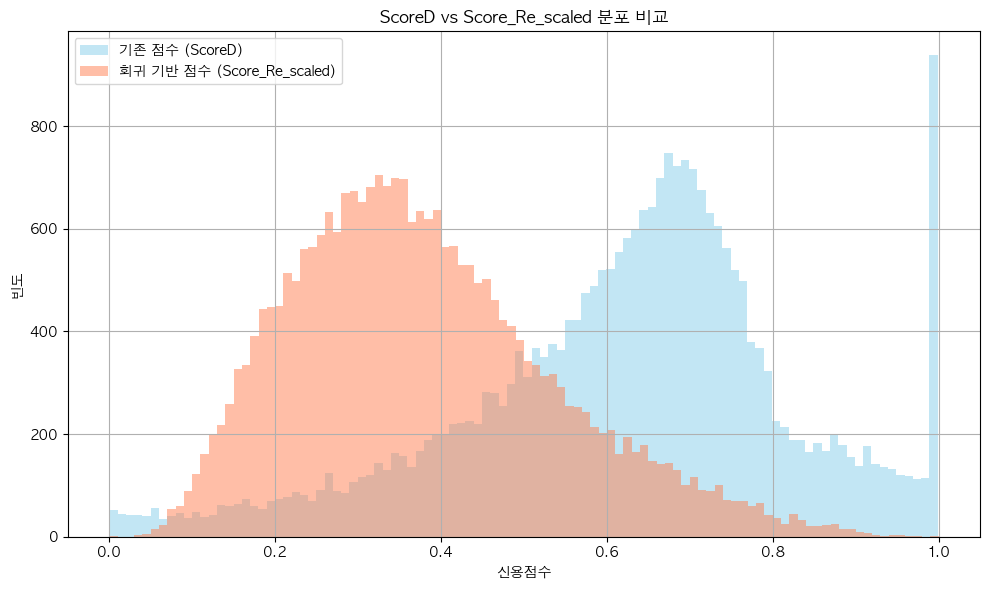

In [39]:
import matplotlib.pyplot as plt

# ✅ ScoreD와 Score_Re_scaled 모두 있는 행 추출
df_plot = df_emp.dropna(subset=['ScoreD']).merge(
    df_score[['Score_Re_scaled']], left_index=True, right_index=True, how='inner'
)

# ✅ 분포 시각화
plt.figure(figsize=(10, 6))
plt.hist(df_plot['ScoreD'], bins=100, alpha=0.5, label='기존 점수 (ScoreD)', color='skyblue')
plt.hist(df_plot['Score_Re_scaled'], bins=100, alpha=0.5, label='회귀 기반 점수 (Score_Re_scaled)', color='coral')
plt.title('ScoreD vs Score_Re_scaled 분포 비교')
plt.xlabel('신용점수')
plt.ylabel('빈도')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [40]:
df_score.head()

Age  FamilyCount  ChildCount  EmployedYears  Default  ApplWeek  ApplHour  \
0  23.3            1           0            0.5        0         5        16   
1  25.2            1           0            2.9        0         2        13   
2  25.4            2           0            1.8        0         4        14   
3  25.7            2           0            0.3        0         2        10   
4  25.8            1           0            0.8        0         4        10   

   CarPrice  Deposit  LoanTerm  LoanRemainTerm  InterestRate  LoanAmount  \
0  15000000       10        24              14          4.30    13500000   
1  15000000       20        36               6          6.49    12000000   
2  18000000       30        48              16          4.58    12600000   
3  20000000       20        48              29          4.73    16000000   
4  25000000       20        48              21          4.43    20000000   

   InstallAmount  LoanRemainAmount  InquiryCount  IdChangedYears  \
0       586687.5         8213625.0             0             0.4   
1       354966.7         2129800.2             0             2.9   
2       274522.5         4392360.0             0             5.2   
3       349100.0        10123900.0             2             5.4   
4       435125.0         9137625.0             1             5.6   

   InfoChangedYears  PhoneChangedYears  ScoreA  ScoreB  ScoreC  loan_months  \
0              22.1                0.0     NaN   0.339   0.539           10   
1              25.0                1.0   0.453   0.673   0.553           30   
2              25.3                0.0   0.438   0.638   0.758           32   
3              17.7                3.6   0.397   0.477   0.397           19   
4               0.0                4.2   0.807   0.767   0.947           27   

  loan_start_date  Gender_남성  Gender_여성  MaritalStatus_결혼  MaritalStatus_독신  \
0      2024-06-01          1          0                 0                 1   
1      2022-10-01          1          0                 0                 1   
2      2022-08-01          1          0                 1                 0   
3      2023-09-01          1          0                 1                 0   
4      2023-01-01          1          0                 0                 1   

   MaritalStatus_이혼  IncomeType_공무원  IncomeType_기타  IncomeType_사업  \
0                 0               0              0              0   
1                 0               0              0              0   
2                 0               0              0              1   
3                 0               0              0              0   
4                 0               0              0              1   

   IncomeType_서비스  OrgType_건설  OrgType_공공  OrgType_교육  OrgType_군/경  \
0               1           0           0           0            0   
1               1           0           0           0            0   
2               0           0           0           0            0   
3               1           0           0           0            0   
4               0           0           0           0            0   

   OrgType_기타  OrgType_농업  OrgType_무역  OrgType_보안  OrgType_산업  OrgType_서비스  \
0           0           0           0           0           0            0   
1           0           0           0           0           0            1   
2           0           0           0           0           0            0   
3           0           0           0           0           0            0   
4           0           0           0           0           0            0   

   OrgType_운송  OrgType_유치원  OrgType_은행/보험  OrgType_일반  OrgType_자영업  \
0           0            0              0           0            1   
1           0            0              0           0            0   
2           0            0              0           1            0   
3           0            0              0           1            0   
4           0            0              0           

In [41]:
df_score.to_csv('df_emp_score.csv', encoding='euc-kr')

### test data에도 적용



In [42]:
dft_emp = pd.read_csv('/Users/minjoo/PoscoBAA/BigData/BigData_Project/Code/정제후데이터/dft_emp.csv', encoding='euc-kr')

In [43]:
dft_emp.head()

Gender   Age Education MaritalStatus  FamilyCount  ChildCount IncomeType  \
0     여성  25.0       대학교            독신            1           0         사업   
1     여성  26.0       대학교            독신            1           0        서비스   
2     남성  26.2       대학원            독신            1           0        서비스   
3     남성  27.0       대학교            결혼            2           0         사업   
4     여성  27.1      고등학교            독신            1           0        서비스   

        IncomeClass Occupation OrgType  EmployedYears HouseOwnYN DwellingType  \
0         3000만원 미만         영업      무역            1.8          Y           자가   
1  3000만원~5000만원 미만         기타     군/경            3.5          N           전세   
2  3000만원~5000만원 미만         기타     서비스            1.7          Y           자가   
3     5000만원~1억원 미만       일반업무   은행/보험            0.7          N           월세   
4  3000만원~5000만원 미만         운전     자영업            1.1          Y           자가   

  HousingType ResidenceClass CarOwnedYN ActiveLoanYN    LoanType ApplWeek  \
0         아파트             양호          N            Y  할부금융(장/단기)        금   
1   연립/다세대/빌라             양호          Y            Y  할부금융(장/단기)        월   
2         아파트             양호          N            Y  할부금융(장/단기)        목   
3   연립/다세대/빌라             양호          Y            Y  할부금융(장/단기)        목   
4        단독주택             양호          Y            N  할부금융(장/단기)        수   

   ApplHour Accompany  CarPrice  Deposit  LoanTerm  LoanRemainTerm  \
0        12        단독  30000000       30        48              48   
1        15        단독  25000000       20        48              48   
2        11        단독  20000000        0        12              12   
3         9        단독  30000000       10        24              24   
4        12        단독  30000000       30        48              48   

  InterestType  LoanAmount  LoanRemainAmount HomeAddMatchedYN  \
0           혼합    21000000          21000000                Y   
1           변동    20000000          20000000                Y   
2           변동    20000000          20000000                N   
3           변동    27000000          27000000                Y   
4           혼합    21000000          21000000                Y   

  WorkAddMatchedYN  InquiryCount  IdChangedYears  InfoChangedYears  \
0                Y             4             4.6              25.0   
1                Y             0             5.7              18.1   
2                N             3             4.5               4.2   
3                Y             5             6.9               2.6   
4                Y             1             5.3              10.2   

   PhoneChangedYears  
0                5.4  
1                6.5  
2                2.2  
3                0.0  
4                0.1

### 가중치 확인

In [44]:
# 회귀 계수 기반 가중치 딕셔너리
weights = {
    'EmployedYears': 0.2094,
    'Age': 0.0953,
    'ResidenceClass_3': 0.0906,
    'Education_2': 0.0845,
    'PhoneChangedYears': 0.0754,
    'IdChangedYears': 0.0509,
    'InfoChangedYears': 0.0447,
    'InterestRate': 0.0421,
    'InquiryCount': 0.0415,
    'Occupation_영업': 0.0345,
    'Occupation_요리': 0.0271,
    'Occupation_노동': 0.0226,
    'IncomeType_서비스': 0.0193,
    'Occupation_보안': 0.0170,
    'OrgType_농업': 0.0156,
    'OrgType_무역': 0.0148,
    'FamilyCount': 0.0136,
    'Occupation_일용직': 0.0123,
    'MaritalStatus_결혼': 0.0122,
    'Education_4': 0.0119
}

# 사용할 변수 리스트
score_vars = list(weights.keys())

# 계산 전: 결측 제거
df_score = df_emp_dummy.copy()
df_score = df_score.dropna(subset=score_vars)

# Score_Re 계산 (가중치 곱의 합산)
df_score['Score_Re'] = sum(df_score[var] * coef for var, coef in weights.items())

# 결과 확인 (상위 10개)
print(df_score[['Score_Re'] + score_vars].head(10))


   Score_Re  EmployedYears   Age  ResidenceClass_3  Education_2  \
0  3.559250            0.5  23.3                 0            0   
1  4.667359            2.9  25.2                 0            0   
2  4.425348            1.8  25.4                 0            0   
3  4.190353            0.3  25.7                 0            0   
4  3.554083            0.8  25.8                 0            1   
5  4.635749            4.6  26.0                 1            1   
6  3.874433            0.2  26.2                 0            1   
7  3.893020            0.3  26.3                 0            1   
8  3.710953            0.7  26.4                 0            1   
9  4.536365            1.7  26.5                 0            1   

   PhoneChangedYears  IdChangedYears  InfoChangedYears  InterestRate  \
0                0.0             0.4              22.1          4.30   
1                1.0             2.9              25.0          6.49   
2                0.0             5.2          

In [45]:
# 예측 모델 scaled

In [46]:
from sklearn.preprocessing import MinMaxScaler

# 스케일러 정의 및 적용
scaler = MinMaxScaler()
df_score['Score_Re_scaled'] = scaler.fit_transform(df_score[['Score_Re']])

# 결과 확인
print(df_score[['Score_Re', 'Score_Re_scaled']].head(10))


   Score_Re  Score_Re_scaled
0  3.559250         0.090889
1  4.667359         0.191619
2  4.425348         0.169620
3  4.190353         0.148258
4  3.554083         0.090420
5  4.635749         0.188746
6  3.874433         0.119540
7  3.893020         0.121230
8  3.710953         0.104679
9  4.536365         0.179712


In [47]:
# Score 평균

In [48]:
# ScoreA, B, C 결측치 제거
df_score_mean = df_emp.dropna(subset=['ScoreA', 'ScoreB', 'ScoreC']).copy()

# 평균 점수 생성
df_score_mean['Score_평균'] = df_score_mean[['ScoreA', 'ScoreB', 'ScoreC']].mean(axis=1)

# 결과 확인
print(df_score_mean[['ScoreA', 'ScoreB', 'ScoreC', 'Score_평균']].head())


   ScoreA  ScoreB  ScoreC  Score_평균
1   0.453   0.673   0.553  0.559667
2   0.438   0.638   0.758  0.611333
3   0.397   0.477   0.397  0.423667
4   0.807   0.767   0.947  0.840333
7   0.336   0.836   0.496  0.556000


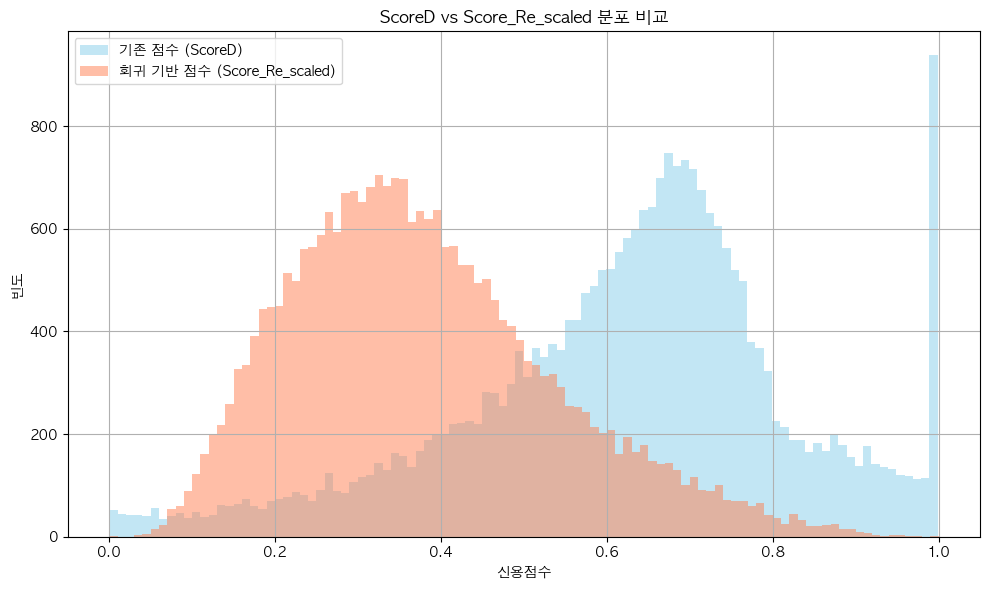

In [49]:
import matplotlib.pyplot as plt

# ✅ ScoreD와 Score_Re_scaled 모두 있는 행 추출
df_plot = df_emp.dropna(subset=['ScoreD']).merge(
    df_score[['Score_Re_scaled']], left_index=True, right_index=True, how='inner'
)

# ✅ 분포 시각화
plt.figure(figsize=(10, 6))
plt.hist(df_plot['ScoreD'], bins=100, alpha=0.5, label='기존 점수 (ScoreD)', color='skyblue')
plt.hist(df_plot['Score_Re_scaled'], bins=100, alpha=0.5, label='회귀 기반 점수 (Score_Re_scaled)', color='coral')
plt.title('ScoreD vs Score_Re_scaled 분포 비교')
plt.xlabel('신용점수')
plt.ylabel('빈도')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
